In [1]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#kaggle.json is your API file that you have to download from Kaggle

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d nicapotato/womens-ecommerce-clothing-reviews

Dataset URL: https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews
License(s): CC0-1.0
  0% 0.00/2.79M [00:00<?, ?B/s]
100% 2.79M/2.79M [00:00<00:00, 255MB/s]


In [3]:
import zipfile
import pandas as pd
import os

zip_filename = 'womens-ecommerce-clothing-reviews.zip'
extract_dir = './clothing_reviews'


if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)


with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
    print("Zip file extracted successfully.")


file_path = os.path.join(extract_dir, 'Womens Clothing E-Commerce Reviews.csv')

df = pd.read_csv(file_path)

print("Dataset loaded successfully.")
df.head()

Zip file extracted successfully.
Dataset loaded successfully.


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
df = df.drop('Unnamed: 0', axis=1)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
import re
from bs4 import BeautifulSoup

def clean_text(text):
  text = BeautifulSoup(str(text), "html.parser").get_text()
  text = text.lower()
  text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)
  text = re.sub(r"[^\x00-\x7f]", " ", text)
  text = re.sub(r"\s+", " ", text).strip()

  return text

In [6]:
df = df.dropna(subset=["Review Text"])
df["Review Text"] = df["Review Text"].astype(str)
df = df[df["Review Text"].str.len() >= 5]

df["Title"] = df["Title"].fillna("")


df["clean_text"] = df.apply(
    lambda row: row["Title"] + ". " + row["Review Text"] if row["Title"].strip() != "" else row["Review Text"],
    axis=1
)

df["clean_text"] = df["clean_text"].astype(str).apply(clean_text)

df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,clean_text
0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolutely wonderful - silky and sexy and comf...
1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,love this dress! it's sooo pretty. i happened ...
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,some major design flaws. i had such high hopes...
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"my favorite buy!. i love, love, love this jump..."
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,flattering shirt. this shirt is very flatterin...


In [7]:
!pip install transformers torch pandas

**Task 1: Classify the review as positive, neutral or negative based on the product reviews in the Review Task column.**

In [8]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        label = torch.argmax(probs, dim=1).item() + 1
    return label


In [10]:
df["sentiment_result"] = df["clean_text"].apply(predict_sentiment)
print(df[["clean_text", "sentiment_result"]].head(10))

                                          clean_text  sentiment_result
0  absolutely wonderful - silky and sexy and comf...                 5
1  love this dress! it's sooo pretty. i happened ...                 5
2  some major design flaws. i had such high hopes...                 3
3  my favorite buy!. i love, love, love this jump...                 5
4  flattering shirt. this shirt is very flatterin...                 5
5  not for the very petite. i love tracy reese dr...                 2
6  cagrcoal shimmer fun. i aded this in my basket...                 3
7  shimmer, surprisingly goes with lots. i ordere...                 4
8  flattering. i love this dress. i usually get a...                 4
9  such a fun dress!. i'm 5"5' and 125 lbs. i ord...                 5


In [11]:
def map_score_to_label(score):
    if score <= 2:
        return "negative"
    elif score == 3:
        return "neutral"
    else:
        return "positive"

df["predicted_sentiment"] = df["sentiment_result"].apply(map_score_to_label)
df["true_sentiment"] = df["Rating"].apply(map_score_to_label)

In [12]:
df.loc[(df["predicted_sentiment"] == "negative") & (df["Recommended IND"] == 1), "predicted_sentiment"] = "neutral"
df.loc[(df["predicted_sentiment"] == "positive") & (df["Recommended IND"] == 0), "predicted_sentiment"] = "neutral"

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_true = df["true_sentiment"]
y_pred = df["predicted_sentiment"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))


Accuracy: 0.8339737644096992

Classification Report:
               precision    recall  f1-score   support

    negative       0.66      0.78      0.71      2370
     neutral       0.40      0.58      0.47      2823
    positive       0.98      0.88      0.93     17448

    accuracy                           0.83     22641
   macro avg       0.68      0.75      0.70     22641
weighted avg       0.87      0.83      0.85     22641


Confusion Matrix:
 [[ 1843   508    19]
 [  900  1635   288]
 [   68  1976 15404]]


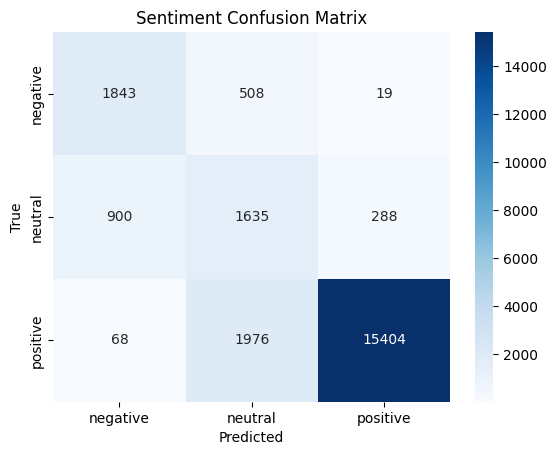

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=["negative", "neutral", "positive"])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Sentiment Confusion Matrix")
plt.show()

**Task 2: Create a system that analyzes "products with positive user experiences" and recommends similar products.**

In [15]:
avg_rating = df.groupby('Clothing ID', as_index=False)['Rating'].mean()
avg_rating.rename(columns={'Rating': 'Average_Rating'}, inplace=True)

other_info = df.drop_duplicates(subset='Clothing ID')

merged_df = other_info.merge(avg_rating, on='Clothing ID', how='left')

print(merged_df.head())

   Clothing ID  Age                    Title  \
0          767   33                            
1         1080   34                            
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  \
0                        0       Initmates        Intimate  Intimates   
1                        4         General         Dresses    Dresses   
2    

In [16]:
merged_df = merged_df[merged_df['Average_Rating'] >= 4.0]

In [17]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [18]:
sentences = df['clean_text'].tolist()
embeddings = model.encode(sentences, show_progress_bar=True)
df['embedding'] = embeddings.tolist()

Batches:   0%|          | 0/708 [00:00<?, ?it/s]

In [19]:
import numpy as np

avg_embeddings = (
    df.groupby('Clothing ID')['embedding']
      .apply(lambda emb_list: np.mean(np.vstack(emb_list), axis=0))
      .reset_index()
)

class_info = df[['Clothing ID', 'Class Name']].drop_duplicates()
avg_embeddings = avg_embeddings.merge(class_info, on='Clothing ID', how='left')

avg_embeddings.rename(columns={'embedding': 'avrEmbedding'}, inplace=True)


In [20]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

emb_matrix = np.vstack(avg_embeddings['avrEmbedding'].values)
cosine_sim_matrix = cosine_similarity(emb_matrix)

product_ids = avg_embeddings['Clothing ID'].values
class_names = avg_embeddings['Class Name'].values

target_id = 767 #example
target_index = np.where(product_ids == target_id)[0][0]

target_class = class_names[target_index]
same_class_indices = np.where(class_names == target_class)[0]


similarities = cosine_sim_matrix[target_index]

filtered_similarities = similarities[same_class_indices]
filtered_ids = product_ids[same_class_indices]


sorted_idx = filtered_similarities.argsort()[::-1]
top_n = 6
top_ids = filtered_ids[sorted_idx][1:top_n]
top_scores = filtered_similarities[sorted_idx][1:top_n]


for pid, score in zip(top_ids, top_scores):
    print(f"Product {pid} (Class: {target_class}) → Similarity: {score:.3f}")


Product 362 (Class: Intimates) → Similarity: 0.727
Product 37 (Class: Intimates) → Similarity: 0.686
Product 78 (Class: Intimates) → Similarity: 0.650
Product 694 (Class: Intimates) → Similarity: 0.642
Product 807 (Class: Intimates) → Similarity: 0.634
